In [ ]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import image as mp_image
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.utils import to_categorical

import keras.layers as L
import keras as K
import keras.layers as L
import os
import cv2
from keras import backend as K

import time

%load_ext tensorboard


In [3]:
!wget http://chaladze.com/l5/img/Linnaeus%205%20128X128.rar

--2022-12-11 16:34:02--  http://chaladze.com/l5/img/Linnaeus%205%20128X128.rar
Resolving chaladze.com (chaladze.com)... 74.208.236.157, 2607:f1c0:100f:f000::25c
Connecting to chaladze.com (chaladze.com)|74.208.236.157|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138983573 (133M) [application/rar]
Saving to: ‘Linnaeus 5 128X128.rar’

Linnaeus 5 128X128. 100%[===================>] 132.54M  11.7MB/s    in 12s     

2022-12-11 16:34:15 (11.1 MB/s) - ‘Linnaeus 5 128X128.rar’ saved [138983573/138983573]



In [4]:
!pip install unrar
!unrar x '/content/Linnaeus 5 128X128.rar'

Streaming output truncated to the last 5000 lines.
Extracting  Linnaeus 5 128X128/train/berry/825_128.jpg                    38%  OK 
Extracting  Linnaeus 5 128X128/train/berry/826_128.jpg                    38%  OK 
Extracting  Linnaeus 5 128X128/train/berry/827_128.jpg                    38%  OK 
Extracting  Linnaeus 5 128X128/train/berry/828_128.jpg                    38%  OK 
Extracting  Linnaeus 5 128X128/train/berry/829_128.jpg                    38%  OK 
Extracting  Linnaeus 5 128X128/train/berry/82_128.jpg                     38%  OK 
Extracting  Linnaeus 5 128X128/train/berry/830_128.jpg                    38%  OK 
Extracting  Linnaeus 5 128X128/train/berry/831_128.jpg                    38%  OK 
Extracting  Linnaeus 5 128X128/train/berry/832_128.jpg                    38%  OK 
Extracting  Linnaeus 5 128X128/train/berry/833_128.jpg                    38%  OK 
Extracting  Linnaeus 5 128X12

In [5]:
training_folder_dir = '/content/Linnaeus 5 128X128/train'
test_folder_dir = '/content/Linnaeus 5 128X128/test'

img_size = (128, 128)

class_names = sorted(os.listdir(training_folder_dir))
class_names

['berry', 'bird', 'dog', 'flower', 'other']

In [6]:
IMG_SIZE = 128

In [7]:
def create_dataset(data_path):
    training_data = []
    for i in range(len(class_names)):
        category = class_names[i]
        path = os.path.join(data_path, category)
        print(path)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([new_array, i])

    return training_data

In [8]:

train_data = create_dataset(training_folder_dir)
test_data = create_dataset(test_folder_dir)

/content/Linnaeus 5 128X128/train/berry
/content/Linnaeus 5 128X128/train/bird
/content/Linnaeus 5 128X128/train/dog
/content/Linnaeus 5 128X128/train/flower
/content/Linnaeus 5 128X128/train/other
/content/Linnaeus 5 128X128/test/berry
/content/Linnaeus 5 128X128/test/bird
/content/Linnaeus 5 128X128/test/dog
/content/Linnaeus 5 128X128/test/flower
/content/Linnaeus 5 128X128/test/other


In [9]:
def extract_X_y(data):
    X = []
    y = []
    for features, label in data:
        X.append(features)
        y.append(label)
    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    X = np.array(X)
    y = np.array(y)
    return X, y

In [10]:
train_X, train_y = extract_X_y(train_data)
test_X, test_y = extract_X_y(test_data)

In [11]:
train_y_eye = np.eye(5)[train_y]

# Q4

In [12]:
def inception_v2(input_img, channel_multiply=1):
    ### 1st layer
    layer_1 = L.Conv2D(16 * channel_multiply, (1, 1), padding='same', activation='relu')(input_img)
    layer_1 = L.Conv2D(16 * channel_multiply, (3, 3), padding='same', activation='relu')(layer_1)

    layer_2 = L.Conv2D(16 * channel_multiply, (1, 1), padding='same', activation='relu')(input_img)
    layer_2 = L.Conv2D(16 * channel_multiply, (5, 5), padding='same', activation='relu')(layer_2)

    layer_3 = L.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_img)
    layer_3 = L.Conv2D(16 * channel_multiply, (1, 1), padding='same', activation='relu')(layer_3)

    layer_4 = L.Conv2D(16 * channel_multiply, (1, 1), padding='same', activation='relu')(input_img)

    mid_1 = tf.keras.layers.concatenate([layer_1, layer_2, layer_3,layer_4], axis=3)
    return mid_1

In [17]:
model = None

In [18]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [19]:
num_classes = 5
input_img = L.Input(shape=(128, 128, 3))
input_img = L.Rescaling(1. / 255)(input_img)
input_img = L.RandomFlip('horizontal')(input_img)
input_img = L.RandomRotation(0.2)(input_img)

c1 = inception_v2(input_img)
p1 = L.AvgPool2D()(c1)

c2 = inception_v2(p1,2)
p2 = L.AvgPool2D(pool_size=(4, 4))(c2)

final = L.Conv2D(32,(1, 1), padding='same', activation='relu')(p2)
final = L.Flatten()(p2)
final = L.Dense(1024, activation='relu')(final)
final = L.Dense(256, activation='relu')(final)
# final = L.Dropout(0.2)(final)
final = L.Dense(num_classes, activation='softmax')(final)

model = keras.Model(inputs=[input_img], outputs=final)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 128, 128, 16  64          ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 16  64          ['input_4[0][0]']                
                                )                                                           

In [20]:
start = time.time()
my_callback = MyThresholdCallback(threshold=0.75)
history = model.fit(x=train_X, y=train_y_eye, batch_size=32, epochs=50, validation_split=0.1,
                              callbacks=[keras.callbacks.TensorBoard(),my_callback])
duration = time.time() - start

Epoch 1/50
  6/169 [>.............................] - ETA: 11s - loss: 1813.8448 - accuracy: 0.2135

169/169 [==============================] - 12s 65ms/step - loss: 95.9871 - accuracy: 0.4026 - val_loss: 2.5327 - val_accuracy: 0.1367
Epoch 2/50
169/169 [==============================] - 11s 64ms/step - loss: 1.1359 - accuracy: 0.5685 - val_loss: 2.8178 - val_accuracy: 0.0733
Epoch 3/50
169/169 [==============================] - 11s 65ms/step - loss: 0.9074 - accuracy: 0.6570 - val_loss: 1.5218 - val_accuracy: 0.4183
Epoch 4/50
169/169 [==============================] - 11s 64ms/step - loss: 0.8007 - accuracy: 0.7083 - val_loss: 3.4602 - val_accuracy: 0.1450
Epoch 5/50
169/169 [==============================] - 11s 64ms/step - loss: 0.6448 - accuracy: 0.7667 - val_loss: 3.4809 - val_accuracy: 0.2117
Epoch 6/50
169/169 [==============================] - 11s 66ms/step - loss: 0.5685 - accuracy: 0.8089 - val_loss: 2.5863 - val_accuracy: 0.4217
Epoch 7/50
169/169 [==============================] - 11s 65ms/step - loss: 0.4305 - accuracy: 0.8452 - val_loss: 3.4947 - val_accuracy: 0.3133
Ep

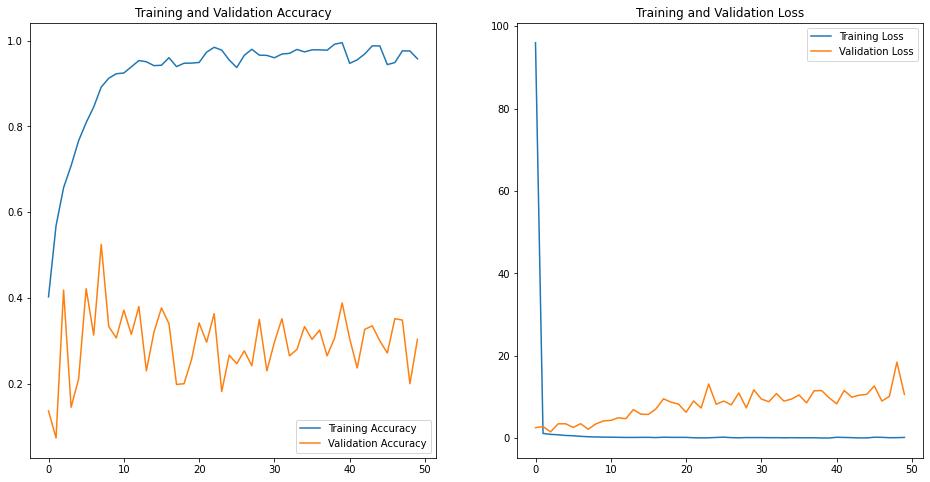

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
pred = model.predict(test_X)
pred
pred = pred.argmax(axis=1)

63/63 [==============================] - 2s 23ms/step


In [25]:
accuracy_score(test_y, pred)

0.431

In [26]:
confusion_matrix(test_y, pred)

array([[190,  34,  30, 115,  31],
       [ 51, 146,  99,  62,  42],
       [ 43,  99, 165,  45,  48],
       [ 82,  18,  23, 249,  28],
       [ 65,  71,  65,  87, 112]])

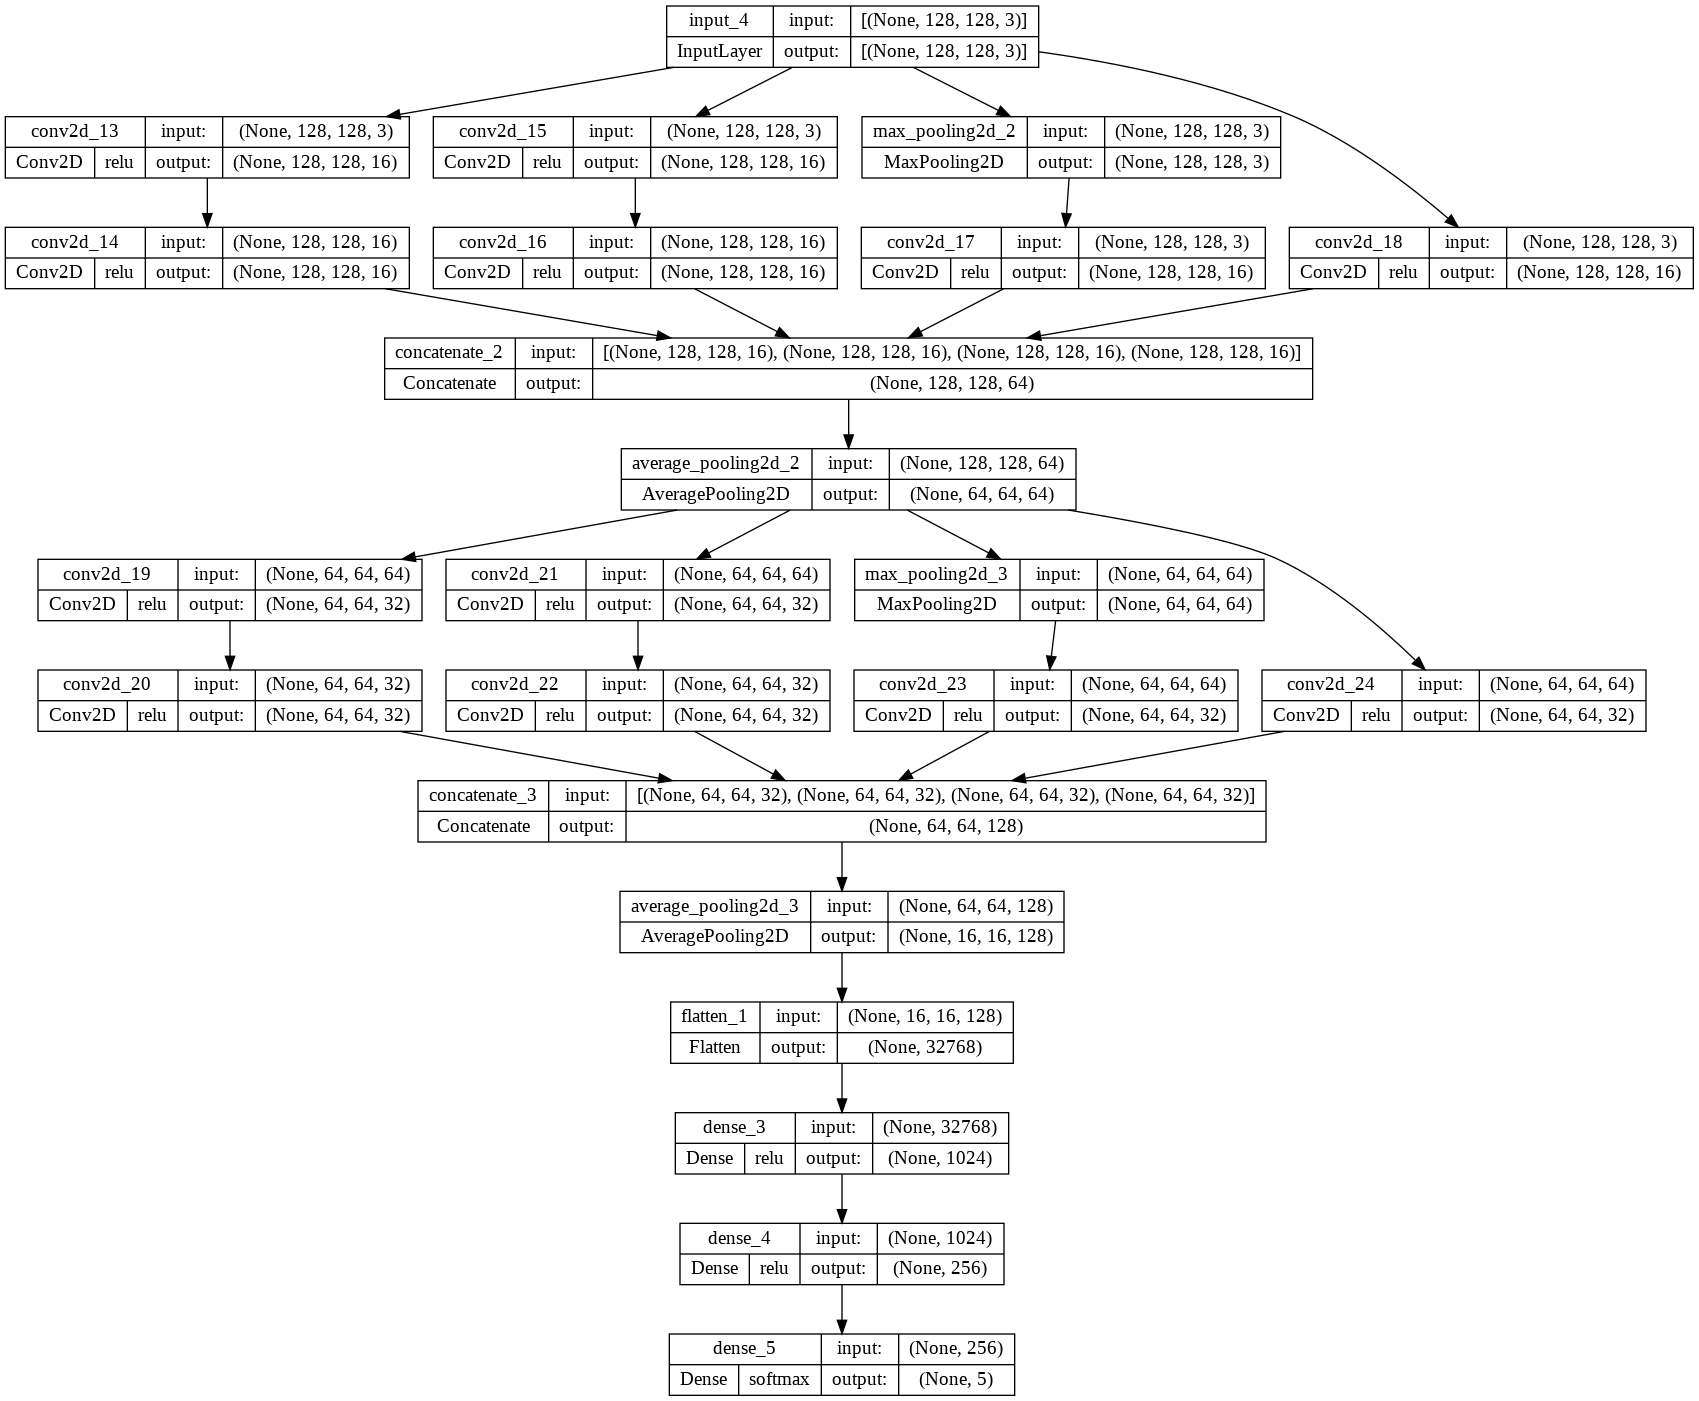

In [27]:
keras.utils.plot_model(model, show_layer_activations=True, show_shapes=True, show_layer_names=True)